In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import scipy.io.wavfile
import copy
import math
from math import pi 


---
VIDEO: Fourier transform for spectral analyses
---


In [2]:
## Generate a multispectral noisy signal

# simulation parameters
srate = 1234 # in Hz
npnts = srate*2 # 2 seconds
time  = np.arange(0,npnts)/srate
print(time)
print(time.shape)
# frequencies to include
frex  = [ 12,18,30 ]

signal = np.zeros(len(time))

# loop over frequencies to create signal
for fi in range(0,len(frex)):
    signal = signal + (fi+1)*np.sin(2*np.pi*frex[fi]*time)

# add some noise
## notes: if noise is large like 20*np.random.randn(len(signal)), even frequency domain cannot provide useful info
signal = signal + np.random.randn(len(signal))

# amplitude spectrum via Fourier transform
signalX = scipy.fftpack.fft(signal)
signalAmp = 2*np.abs(signalX)/npnts

# vector of frequencies in Hz
hz = np.linspace(0,srate/2,int(np.floor(npnts/2)+1))


[0.00000000e+00 8.10372771e-04 1.62074554e-03 ... 1.99756888e+00
 1.99837925e+00 1.99918963e+00]
(2468,)


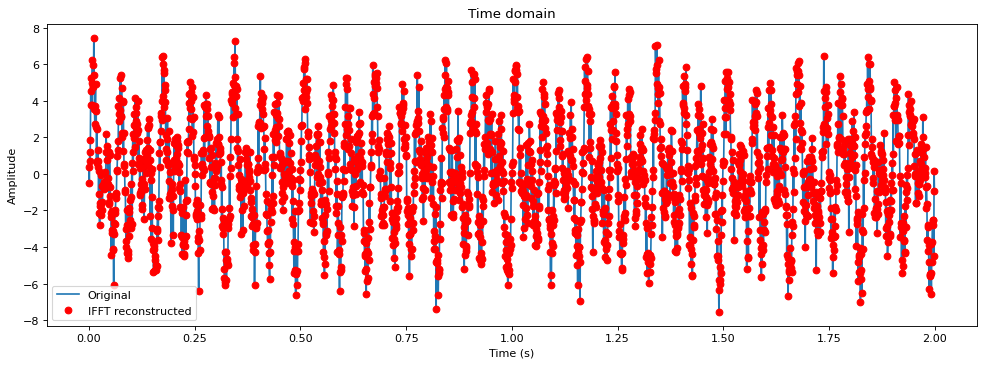

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()


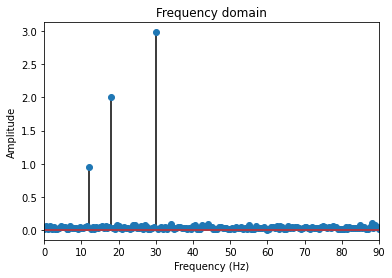

notes: if noise is large like 20*np.random.randn(len(signal)), even frequency domain cannot provide useful info


In [3]:
## plots
from matplotlib.pyplot import figure
figure(figsize=(15, 5), dpi=80)

plt.plot(time,signal,label='Original')
## notes: r = red, o = circle
## ref: https://www.mathworks.com/matlabcentral/answers/282940-what-is-the-ro-in-plot-mean#answer_221098
plt.plot(time,np.real(scipy.fftpack.ifft(signalX)),'ro',label='IFFT reconstructed')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time domain')
plt.legend()
plt.show()

plt.stem(hz,signalAmp[0:len(hz)],'k')
plt.xlim([0,np.max(frex)*3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain')
plt.show()


from termcolor import colored
print(colored("notes: if noise is large like 20*np.random.randn(len(signal)), even frequency domain cannot provide useful info", 'red'))

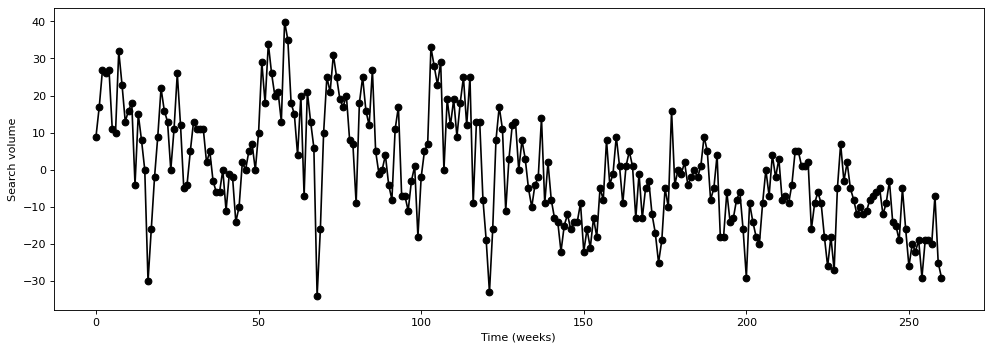

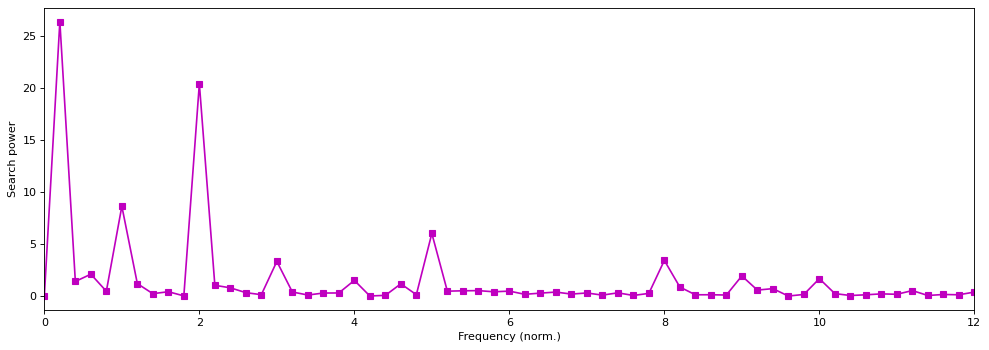

notes: x asix mean fraction of the year, for example every half year (2 faction) there is a peak
notes: there is a peak at 0, but the peak was generated artificially by removing mean


In [4]:
## example with real data

# data downloaded from https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=signal%20processing
searchdata = [69,77,87,86,87,71,70,92,83,73,76,78,56,75,68,60,30,44,58,69,82,76,73,60,71,86,72,55,56,65,73,71,71,71,62,65,57,54,54,60,49,59,58,46,50,62,60,65,67,60,70,89,78,94,86,80,81,73,100,95,78,75,64,80,53,81,73,66,26,44,70,85,81,91,85,79,77,80,68,67,51,78,85,76,72,87,65,59,60,64,56,52,71,77,53,53,49,57,61,42,58,65,67,93,88,83,89,60,79,72,79,69,78,85,72,85,51,73,73,52,41,27,44,68,77,71,49,63,72,73,60,68,63,55,50,56,58,74,51,62,52,47,46,38,45,48,44,46,46,51,38,44,39,47,42,55,52,68,56,59,69,61,51,61,65,61,47,59,47,55,57,48,43,35,41,55,50,76,56,60,59,62,56,58,60,58,61,69,65,52,55,64,42,42,54,46,47,52,54,44,31,51,46,42,40,51,60,53,64,58,63,52,53,51,56,65,65,61,61,62,44,51,54,51,42,34,42,33,55,67,57,62,55,52,48,50,48,49,52,53,54,55,48,51,57,46,45,41,55,44,34,40,38,41,31,41,41,40,53,35,31]
N = len(searchdata)

# possible normalizations... 
## notes: so that 0 frequency won't dominate the graph
## shouldn't use detrend as it is a downward going trend so we shouldn't remove the trend
searchdata = searchdata - np.mean(searchdata)

# power
searchpow = np.abs( scipy.fftpack.fft( searchdata )/N )**2
hz = np.linspace(0,52,N)

figure(figsize=(15, 5), dpi=80)
plt.plot(searchdata,'ko-')
plt.xlabel('Time (weeks)')
plt.ylabel('Search volume')
plt.show()

figure(figsize=(15, 5), dpi=80)
plt.plot(hz,searchpow,'ms-')
plt.xlabel('Frequency (norm.)')
plt.ylabel('Search power')
plt.xlim([0,12])
plt.show()

from termcolor import colored
print(colored("notes: x asix mean fraction of the year, for example every half year (2 faction) there is a peak", 'red'))
print(colored("notes: there is a peak at 0, but the peak was generated artificially by removing mean", 'red'))


---
# VIDEO: Welch's method
---


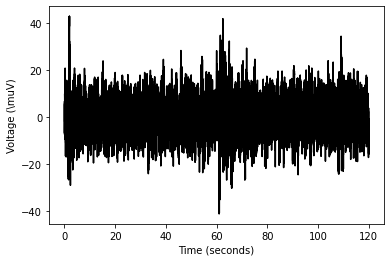

In [5]:
# load data and extract
matdat  = sio.loadmat('EEGrestingState.mat')
eegdata = matdat['eegdata'][0]
srate   = matdat['srate'][0]

# time vector
N = len(eegdata)
timevec = np.arange(0,N)/srate

# plot the data
plt.plot(timevec,eegdata,'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (\muV)')
plt.show()

In [6]:
## one big FFT (not Welch's method)

# "static" FFT over entire period, for comparison with Welch
eegpow = np.abs( scipy.fftpack.fft(eegdata)/N )**2
hz = np.linspace(0,srate/2,int(np.floor(N/2)+1))


showing the first window


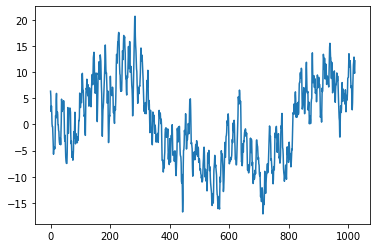

removing edge effect in fourir transform by applying Hann taper


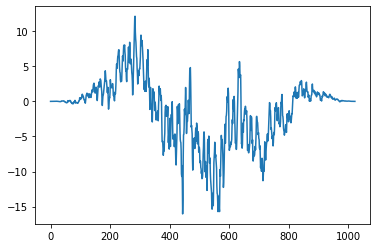

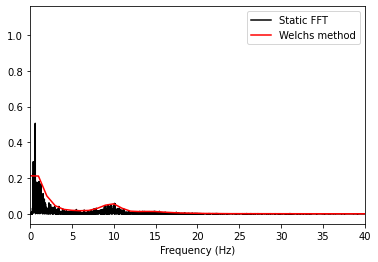

In [10]:
## "manual" Welch's method

# window length in seconds*srate
winlength = int( 1*srate )

# number of points of overlap
nOverlap = np.round(srate/2)

# window onset times
winonsets = np.arange(0,int(N-winlength),int(winlength-nOverlap))

# note: different-length signal needs a different-length Hz vector
hzW = np.linspace(0,srate/2,int(np.floor(winlength/2)+1))

# Hann window
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,int(winlength)))/2

# initialize the power matrix (windows x frequencies)
eegpowW = np.zeros(len(hzW))

# loop over frequencies
for wi in range(0,len(winonsets)):
    
    # get a chunk of data from this time window
    datachunk = eegdata[ winonsets[wi]:winonsets[wi]+winlength ]
    if wi == 0:
      print("showing the first window")
      plt.plot(datachunk)
      plt.show()

    # apply Hann taper to data
    datachunk = datachunk * hannw
    if wi == 0:
      print("removing edge effect in fourir transform by applying Hann taper")
      plt.plot(datachunk)
      plt.show()

    # compute its power
    tmppow = np.abs(scipy.fftpack.fft(datachunk)/winlength)**2
    
    # enter into matrix
    eegpowW = eegpowW  + tmppow[0:len(hzW)]

# divide by N
eegpowW = eegpowW / len(winonsets)


# plotting
plt.plot(hz,eegpow[0:len(hz)],'k',label='Static FFT')
plt.plot(hzW,eegpowW/10,'r',label='Welch''s method')
plt.xlim([0,40])
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

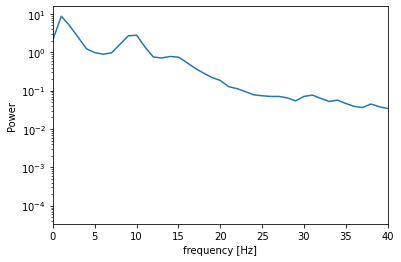

In [15]:
## Python's welch

# create Hann window
winsize = int( 1*srate ) # 1-second window
hannw = .5 - np.cos(2*pi*np.linspace(0,1,winsize))/2

# number of FFT points (frequency resolution)
nfft = srate*1

f, welchpow = scipy.signal.welch(eegdata,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)

plt.semilogy(f,welchpow)
plt.xlim([0,40])
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.show()


---
# VIDEO: Spectrogram of birdsong
---


44100
(450879, 2)


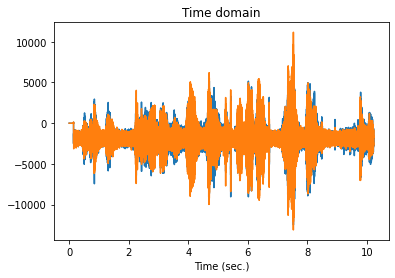

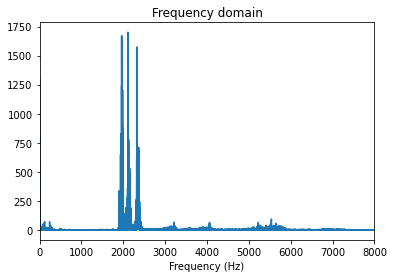

In [31]:
## load in birdcall (source: https://www.xeno-canto.org/403881)
from IPython.display import Audio

fs,bc = scipy.io.wavfile.read('XC403881.wav')

# create a time vector based on the data sampling rate
n = len(bc)
timevec = np.arange(0,n)/fs

# play the music! may not work
# Audio(np.array(bc[:,0]), rate=n)
print(fs)
print(bc.shape)
# plot the data from the two channels
plt.plot(timevec,bc)
plt.xlabel('Time (sec.)')
plt.title('Time domain')
plt.show()

# compute the power spectrum
hz = np.linspace(0,fs/2,int(np.floor(n/2)+1))
bcpow = np.abs(scipy.fftpack.fft( scipy.signal.detrend(bc[:,0]) )/n)**2

# now plot it
plt.plot(hz,bcpow[0:len(hz)])
plt.xlabel('Frequency (Hz)')
plt.title('Frequency domain')
plt.xlim([0,8000])
plt.show()

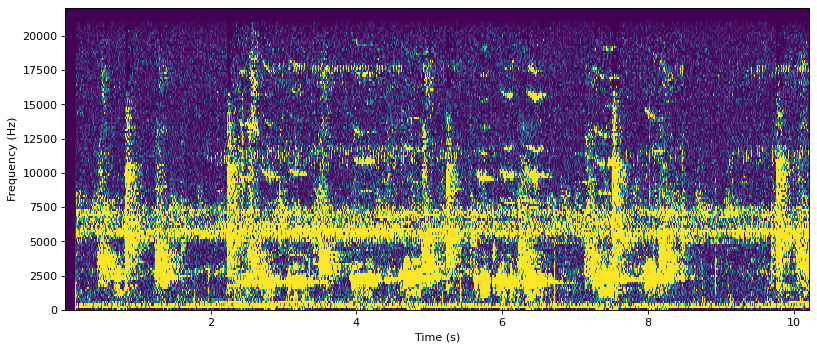

In [32]:
from matplotlib.pyplot import figure
figure(figsize=(12, 5), dpi=80)

## time-frequency analysis via spectrogram

frex,time,pwr = scipy.signal.spectrogram(bc[:,0],fs)

plt.pcolormesh(time,frex,pwr,vmin=0,vmax=9)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.show()